# Hyper parameter tunning

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-dataset" data-toc-modified-id="The-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The dataset</a></span></li><li><span><a href="#Hyper-parameter-tunning-with-Keras" data-toc-modified-id="Hyper-parameter-tunning-with-Keras-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hyper-parameter tunning with Keras</a></span></li><li><span><a href="#Fit-the-best-architecture" data-toc-modified-id="Fit-the-best-architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit the best architecture</a></span></li></ul></div>

## The dataset

In [1]:
import tensorflow as tf
import numpy as np 

''' Load dataset '''
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

_, img_rows, img_cols =  X_train.shape
num_classes = len(np.unique(y_train))
num_input_nodes = img_rows*img_cols

print("Number of training samples: %d"%X_train.shape[0])
print("Number of test samples: %d"%X_test.shape[0])
print("Image size: %d*%d"%(X_train.shape[1], X_train.shape[2]))
print("Number of classes: %d"%num_classes)

Number of training samples: 60000
Number of test samples: 10000
Image size: 28*28
Number of classes: 10


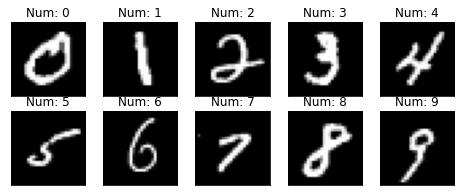

In [2]:
''' Show Examples from Each Class '''
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1+i, xticks=[], yticks=[])
    features_idx = X_train[y_train[:]==i,:]
    ax.set_title("Num: " + str(i))
    plt.imshow(features_idx[1], cmap="gray")
    
plt.show()

In [3]:
'''
Pre-processing
'''
# rescale the images from [0,255] to the [0.0,1.0] range.
X_train = X_train/255
X_test = X_test/255


# Filter the dataset to keep only the 0 and 1,
# conserve only 1000 items
# delete the other classes.
def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    return x[:1000],y[:1000]

X_train, y_train = filter_01(X_train, y_train)
X_test, y_test = filter_01(X_test, y_test)

print("Number of filtered training examples:", len(X_train))
print("Number of filtered test examples:", len(X_test))

Number of filtered training examples: 1000
Number of filtered test examples: 1000


In [4]:
X_train.shape

(1000, 28, 28)

## Hyper-parameter tunning with Keras

In [4]:
def Build_Model(activation, neurons, optimizer, dropout):
    inputs = tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2],))
    x = tf.keras.layers.Dense(units=10*neurons, input_shape=(), activation=activation)(inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(units=neurons, activation=activation)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')
    model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

    return model

In [5]:
model = Build_Model('relu', 10, 'SGD', 0.5)
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
dense (Dense)                (None, 28, 100)           2900      
_________________________________________________________________
dropout (Dropout)            (None, 28, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 28, 10)            1010      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 10)            0         
_________________________________________________________________
flatten (Flatten)            (None, 280)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 

In [6]:
# Definying grid parameters
activation = ['relu', 'tanh', 'sigmoid']
neurons = [10, 25, 50]
dropout = [0.25, 0.5]
optimizer = ['SGD', 'Adam', 'Adamax']

param_grid = dict(activation = activation,
                  neurons = neurons,
                  dropout = dropout,
                  optimizer = optimizer)

In [30]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

clf = KerasClassifier(build_fn=Build_Model, epochs=50, batch_size=40, verbose= 0)

model = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1)
%time model.fit(X_train,y_train)

print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), 
                                                   model.best_params_))

CPU times: user 9.26 s, sys: 1.63 s, total: 10.9 s
Wall time: 46min 25s
Max Accuracy Registred: 0.999 using {'activation': 'tanh', 'dropout': 0.5, 'neurons': 10, 'optimizer': 'SGD'}


In [48]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV


clf = KerasClassifier(build_fn=Build_Model, epochs=50, batch_size=40, verbose= 0)

model = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, random_state=1960, n_jobs=-1)
%time model.fit(X_train,y_train)

print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), 
                                                   model.best_params_))

CPU times: user 5.43 s, sys: 981 ms, total: 6.41 s
Wall time: 1min 29s
Max Accuracy Registred: 0.998 using {'optimizer': 'Adam', 'neurons': 10, 'dropout': 0.5, 'activation': 'sigmoid'}


Even if we are not sure with RandomizedSearchCV to find the best model, this approach is preferable because the execution time is much shorter than with GridSearchCV.

## Fit the best architecture

In [49]:
model = Build_Model(model.best_params_['activation'],
                    model.best_params_['neurons'],
                    model.best_params_['optimizer'],
                    model.best_params_['dropout'])
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
dense_26 (Dense)             (None, 28, 100)           2900      
_________________________________________________________________
dropout_12 (Dropout)         (None, 28, 100)           0         
_________________________________________________________________
dense_27 (Dense)             (None, 28, 10)            1010      
_________________________________________________________________
dropout_13 (Dropout)         (None, 28, 10)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 280)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 

In [54]:
# simple early stopping
# try with patience 0 and 100
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# fit model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=4000, callbacks=[es, mc], verbose=1)

Epoch 1/4000
 1/29 [>.............................] - ETA: 0s - loss: 0.7341 - accuracy: 0.5625
Epoch 00001: val_accuracy improved from -inf to 0.54000, saving model to best_model.h5
29/29 [==============================] - 0s 4ms/step - loss: 0.7182 - accuracy: 0.5344 - val_loss: 0.6526 - val_accuracy: 0.5400
Epoch 2/4000
21/29 [====================>.........] - ETA: 0s - loss: 0.7017 - accuracy: 0.5610
Epoch 00002: val_accuracy improved from 0.54000 to 0.74000, saving model to best_model.h5
29/29 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5733 - val_loss: 0.6300 - val_accuracy: 0.7400
Epoch 3/4000
28/29 [===========================>..] - ETA: 0s - loss: 0.6518 - accuracy: 0.6239
Epoch 00003: val_accuracy improved from 0.74000 to 0.77000, saving model to best_model.h5
29/29 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6211 - val_loss: 0.5933 - val_accuracy: 0.7700
Epoch 4/4000
26/29 [=========================>....] - ETA:

<ipython-input-57-33c0847d354e>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-57-33c0847d354e>:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


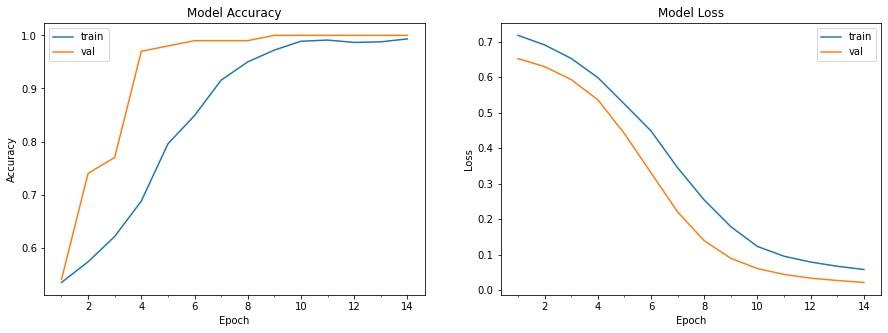

In [57]:
'''
Plot Accuracy or Loss as a Function of Number of Epoch
'''
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    txt = ['train', 'val']
    
    axs[0].legend(txt, loc='best')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    
    axs[1].legend(txt, loc='best')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    
    plt.show()
    
plot_model_history(history)